# Image classification on CIFAR-10 dataset

by Adrian Rosebrock on October 8, 2018 in Deep Learning, Keras

https://www.pyimagesearch.com/2018/10/08/keras-vs-tensorflow-which-one-is-better-and-which-one-should-i-learn/

Keras vs TensorFlow – Which one is better and which one should I learn?
If you’re asking “Keras vs TensorFlow”, you’re asking the wrong question!
As of mid-2017, Keras was actually fully adopted and integrated into TensorFlow. 

This TensorFlow + Keras integration means that you can:
* Define your model using the easy to use interface of Keras
* And then drop down into TensorFlow if you need 
  (1) specific TensorFlow functionality or 
  (2) need to implement a custom feature that Keras does not support but TensorFlow does.

In short:
You can insert TensorFlow code directly into your Keras model or training pipeline!

### Objective: train a neural network using Keras  
ie, implement a Convolutional Neural Network (CNN) using both the standard keras module along with the tf.keras module baked right into TensorFlow.

Keras as a library will still operate independently and separately from TensorFlow,  
so there is a possibility that the two will diverge in the future; 
however, given that Google officially supports both Keras and TensorFlow, that divergence seems extremely unlikely.

In [2]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.core import Dense

# Option 1: define the 3072-1024-512-3 architecture using Keras
# simple feedforward neural network using the standard Keras package
model = Sequential()
model.add(Dense(1024, input_shape=(3072,), activation="sigmoid"))
model.add(Dense(512, activation="sigmoid"))
model.add(Dense(10, activation="softmax"))

# # Option 2: define the 3072-1024-512-3 architecture using tf.keras, end result is the same as Option 1.
# # implement the same network using the  tf.keras  submodule which is part of TensorFlow:
# import tensorflow as tf
# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Dense(1024, input_shape=(3072,), activation="sigmoid"))
# model.add(tf.keras.layers.Dense(512, activation="sigmoid"))
# model.add(tf.keras.layers.Dense(10, activation="softmax"))

dataset: https://www.cs.toronto.edu/~kriz/cifar.html

The CIFAR-10 dataset itself consists of 10 separate classes with 50,000 training images and 10,000 testing images, each size is 32x32 pixel.

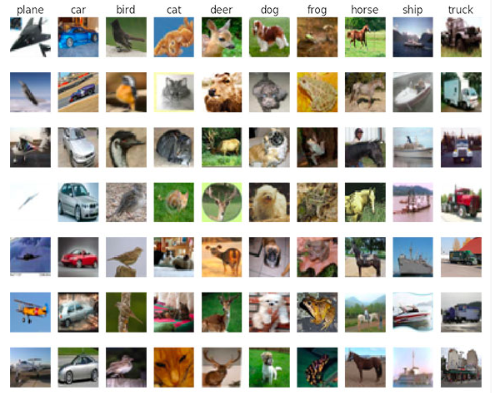

In [3]:
# The first step in training our network is to implement the network architecture itself in Keras

# import the necessary packages
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model

class MiniVGGNetKeras:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the input shape and channel dimension, assuming
        # TensorFlow/channels-last ordering
        inputShape = (height, width, depth)
        chanDim = -1

        # define the model input
        inputs = Input(shape=inputShape)

# Let’s start defining the body of the Convolutional Neural Network:
        # first (CONV => RELU) * 2 => POOL layer set
        x = Conv2D(32, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

# Let’s add the fully-connected (FC) layers to the network:
        # second (CONV => RELU) * 2 => POOL layer set
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = Conv2D(64, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        # first (and only) set of FC => RELU layers
        x = Flatten()(x)
        x = Dense(512)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)

        # softmax classifier
        x = Dense(classes)(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="minivggnet_keras")

        # return the constructed network architecture
        return model

# Our FC and Softmax classifier are appended onto the network. 
# We then define the neural network model and return it to the calling function.

### Now that we’ve implemented our CNN in Keras, let’s create the driver script that will be used to train it.

In [5]:
# import the necessary packages
# from pyimagesearch.minivggnetkeras import MiniVGGNetKeras
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import time   # time1 = time.time(); print('Time taken: {:.1f} seconds'.format(time.time() - time1))

# load the training and testing data, then scale it into the range [0, 1]
print("[INFO] loading CIFAR-10 data...")
split = cifar10.load_data()
((trainX, trainY), (testX, testY)) = split
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Next, let’s train the model
# initialize the initial learning rate, total number of epochs to train for, and batch size
INIT_LR = 0.01
EPOCHS = 30
BS = 32

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model = MiniVGGNetKeras.build(width=32, height=32, depth=3, classes=len(labelNames))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network for {} epochs...".format(EPOCHS))
time1 = time.time()   # measure the time taken
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=BS, epochs=EPOCHS, verbose=1)
print('Time taken: {:.1f} seconds'.format(time.time() - time1))   # measure the time taken

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
[INFO] training network for 30 epochs...
Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 467s 9ms/step - loss: 1.7352 - acc: 0.4207 - val_loss: 1.6448 - val_acc: 0.4381
Epoch 2/30
50000/50000 [==============================] - 449s 9ms/step - loss: 1.2459 - acc: 0.5556 - val_loss: 1.0934 - val_acc: 0.6131
Epoch 3/30
50000/50000 [==============================] - 452s 9ms/step - loss: 1.1179 - acc: 0.6054 - val_loss: 0.9804 - val_acc: 0.6513
Epoch 4/30
50000/50000 [==============================] - 452s 9ms/step - loss: 1.0457 - acc: 0.6293 - val_loss: 1.0219 - val_acc: 0.6310
Epoch 5/30
50000/50000 [==============================] - 456s 9ms/step - loss: 1.0054 - acc: 0.6477 - val_loss: 0.8881 - val_acc: 0.689

In [ ]:
# results from terminal, executed the following command:
# python train_network_keras.py

# (metis) C:\Users\ASUS\py\Metis\project05_Project_Kojak>python train_network_keras.py
# Using TensorFlow backend.
# [INFO] loading CIFAR-10 data...
# Downloading data from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# 170500096/170498071 [==============================] - 102s 1us/step
# [INFO] compiling model...
# [INFO] training network for 30 epochs...
# Train on 50000 samples, validate on 10000 samples
# Epoch 1/30
# 50000/50000 [==============================] - 514s 10ms/step - loss: 1.7632 - acc: 0.4175 - val_loss: 1.2794 - val_acc: 0.5443
# Epoch 2/30
# 50000/50000 [==============================] - 446s 9ms/step - loss: 1.2896 - acc: 0.5420 - val_loss: 1.2153 - val_acc: 0.5728
# Epoch 3/30
# 50000/50000 [==============================] - 447s 9ms/step - loss: 1.1579 - acc: 0.5870 - val_loss: 1.0713 - val_acc: 0.6156
# Epoch 4/30
# 50000/50000 [==============================] - 446s 9ms/step - loss: 1.0807 - acc: 0.6145 - val_loss: 0.9724 - val_acc: 0.6522
# Epoch 5/30
# 50000/50000 [==============================] - 444s 9ms/step - loss: 1.0368 - acc: 0.6330 - val_loss: 0.9727 - val_acc: 0.6576
# Epoch 6/30
# 50000/50000 [==============================] - 440s 9ms/step - loss: 0.9977 - acc: 0.6461 - val_loss: 0.9044 - val_acc: 0.6835
# Epoch 7/30
# 50000/50000 [==============================] - 451s 9ms/step - loss: 0.9661 - acc: 0.6595 - val_loss: 0.8581 - val_acc: 0.7024
# Epoch 8/30
# 50000/50000 [==============================] - 438s 9ms/step - loss: 0.9387 - acc: 0.6693 - val_loss: 0.8688 - val_acc: 0.6930
# Epoch 9/30
# 50000/50000 [==============================] - 441s 9ms/step - loss: 0.9205 - acc: 0.6761 - val_loss: 0.8468 - val_acc: 0.7000
# Epoch 10/30
# 50000/50000 [==============================] - 433s 9ms/step - loss: 0.9018 - acc: 0.6821 - val_loss: 0.8756 - val_acc: 0.6919
# Epoch 11/30
# 50000/50000 [==============================] - 432s 9ms/step - loss: 0.8898 - acc: 0.6893 - val_loss: 0.8075 - val_acc: 0.7172
# Epoch 12/30
# 50000/50000 [==============================] - 454s 9ms/step - loss: 0.8744 - acc: 0.6914 - val_loss: 0.7871 - val_acc: 0.7262
# Epoch 13/30
# 50000/50000 [==============================] - 460s 9ms/step - loss: 0.8652 - acc: 0.6961 - val_loss: 0.8017 - val_acc: 0.7205
# Epoch 14/30
# 50000/50000 [==============================] - 463s 9ms/step - loss: 0.8503 - acc: 0.6998 - val_loss: 0.7879 - val_acc: 0.7242
# Epoch 15/30
# 50000/50000 [==============================] - 463s 9ms/step - loss: 0.8476 - acc: 0.7011 - val_loss: 0.7681 - val_acc: 0.7297
# Epoch 16/30
# 50000/50000 [==============================] - 452s 9ms/step - loss: 0.8340 - acc: 0.7087 - val_loss: 0.7684 - val_acc: 0.7304
# Epoch 17/30
# 50000/50000 [==============================] - 434s 9ms/step - loss: 0.8333 - acc: 0.7086 - val_loss: 0.7625 - val_acc: 0.7309
# Epoch 18/30
# 50000/50000 [==============================] - 433s 9ms/step - loss: 0.8209 - acc: 0.7115 - val_loss: 0.7745 - val_acc: 0.7289
# Epoch 19/30
# 50000/50000 [==============================] - 435s 9ms/step - loss: 0.8138 - acc: 0.7151 - val_loss: 0.7523 - val_acc: 0.7345
# Epoch 20/30
# 50000/50000 [==============================] - 436s 9ms/step - loss: 0.8091 - acc: 0.7161 - val_loss: 0.7700 - val_acc: 0.7299
# Epoch 21/30
# 50000/50000 [==============================] - 434s 9ms/step - loss: 0.8019 - acc: 0.7181 - val_loss: 0.7318 - val_acc: 0.7439
# Epoch 22/30
# 50000/50000 [==============================] - 433s 9ms/step - loss: 0.7905 - acc: 0.7199 - val_loss: 0.7606 - val_acc: 0.7331
# Epoch 23/30
# 50000/50000 [==============================] - 433s 9ms/step - loss: 0.7925 - acc: 0.7233 - val_loss: 0.7390 - val_acc: 0.7426
# Epoch 24/30
# 50000/50000 [==============================] - 435s 9ms/step - loss: 0.7888 - acc: 0.7234 - val_loss: 0.7343 - val_acc: 0.7425
# Epoch 25/30
# 50000/50000 [==============================] - 434s 9ms/step - loss: 0.7840 - acc: 0.7267 - val_loss: 0.7310 - val_acc: 0.7493
# Epoch 26/30
# 50000/50000 [==============================] - 434s 9ms/step - loss: 0.7739 - acc: 0.7272 - val_loss: 0.7095 - val_acc: 0.7525
# Epoch 27/30
# 50000/50000 [==============================] - 433s 9ms/step - loss: 0.7705 - acc: 0.7279 - val_loss: 0.7152 - val_acc: 0.7522
# Epoch 28/30
# 50000/50000 [==============================] - 435s 9ms/step - loss: 0.7656 - acc: 0.7307 - val_loss: 0.7103 - val_acc: 0.7519
# Epoch 29/30
# 50000/50000 [==============================] - 435s 9ms/step - loss: 0.7680 - acc: 0.7288 - val_loss: 0.7153 - val_acc: 0.7511
# Epoch 30/30
# 50000/50000 [==============================] - 433s 9ms/step - loss: 0.7653 - acc: 0.7312 - val_loss: 0.7184 - val_acc: 0.7477
# [INFO] evaluating network...
#               precision    recall  f1-score   support

#     airplane       0.85      0.67      0.75      1000
#          car       0.91      0.80      0.85      1000
#         bird       0.73      0.55      0.63      1000
#          cat       0.62      0.52      0.56      1000
#         deer       0.61      0.83      0.70      1000
#          dog       0.68      0.65      0.67      1000
#         frog       0.72      0.90      0.80      1000
#        horse       0.86      0.77      0.82      1000
#         ship       0.77      0.92      0.84      1000
#        truck       0.80      0.86      0.83      1000

#    micro avg       0.75      0.75      0.75     10000
#    macro avg       0.75      0.75      0.74     10000
# weighted avg       0.75      0.75      0.74     10000

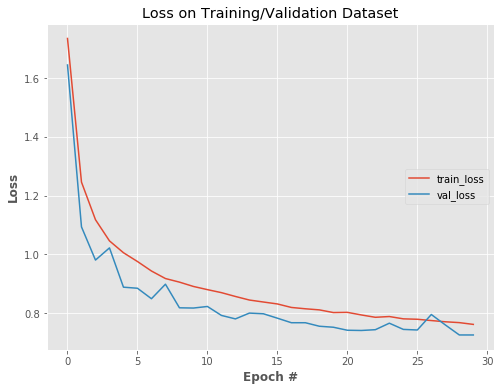

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the training/validation loss
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Loss on Training/Validation Dataset")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend(loc="right")

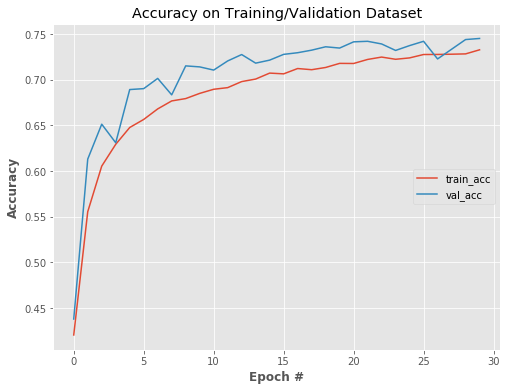

In [7]:
# plot the training/validation accuracy
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")
plt.title("Accuracy on Training/Validation Dataset")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend(loc="right")

In [8]:
model.summary()

Model: "minivggnet_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)   

In [9]:
# save model architecture and weights to a single HDF5 file
model.save("CIFAR-10_keras_model.h5")
print("Saved model to disk")

Saved model to disk


## Make predictions, to test the model using new images

In [14]:
from keras.models import load_model
import cv2

# load model
model = load_model('CIFAR-10_keras_model.h5')
# model.summary()

Text(0, 0.5, 'Category')

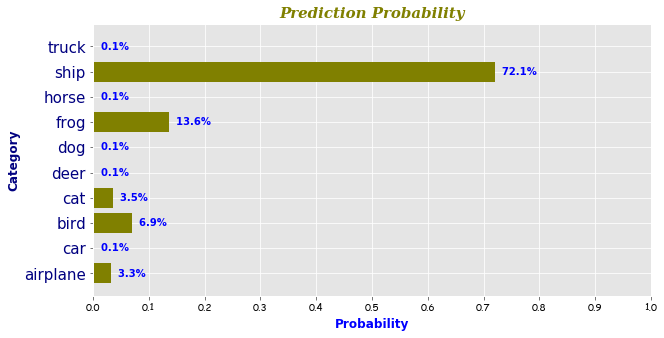

In [17]:
# load the input image and resize it to the target spatial dimensions
image = cv2.imread("img\cifar09.jpg")
image = cv2.resize(image, (32, 32))   # height, width

# scale the pixel values to [0, 1]
image = image.astype("float") / 255.0

# when working with a CNN: don't flatten the image, simply add the batch dimension (expected input to have 4 dimensions)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# make a prediction on the image
preds = model.predict(image)

# plot the prediction probability for each category
plt.figure(figsize = [10,5])   # [width, height]

x = ["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
y = [ preds[0][0], preds[0][1], preds[0][2], preds[0][3], preds[0][4], preds[0][5], preds[0][6], preds[0][7], preds[0][8], preds[0][9] ]
plt.barh(x, y, color='olive')

ticks_x = np.linspace(0, 1, 11)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks( size=15, color='navy' )
for i, v in enumerate(y):
    plt.text(v, i, "  "+str((v*100).round(1))+"%", color='blue', va='center', fontweight='bold')

plt.title('Prediction Probability', family='serif', fontsize=15, style='italic', weight='bold', color='olive', loc='center', rotation=0)
plt.xlabel('Probability', fontsize=12, weight='bold', color='blue')
plt.ylabel('Category', fontsize=12, weight='bold', color='navy')